In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import requests
from scipy.stats import norm
from io import StringIO
import seaborn as sns
import warnings

In [60]:
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10,6)

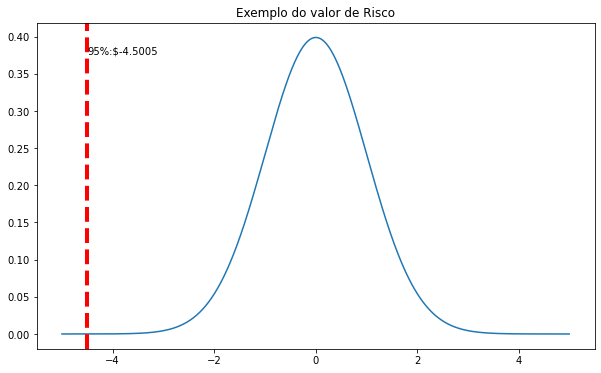

In [61]:
mean = 0
std_dev = 1
x = np.arange(-5,5,0.01)
y = norm.pdf(x, mean, std_dev)
pdf = plt.plot(x,y)
min_ylim,max_ylim = plt.ylim()
plt.text(np.percentile(x, 5), max_ylim * 0.9, '95%:${:.4f}'
         .format(np.percentile(x, 5)))
plt.axvline(np.percentile(x, 5), color='r', linestyle='dashed', linewidth=4)
plt.title('Exemplo do valor de Risco')
plt.show()

In [62]:
def getDailyData(symbol):
    parameters={'function':'TIME_SERIES_DAILY_ADJUSTED',
                'symbol':symbol,
                'outputsize':'full',
                'datatype':'csv',
                'apikey':'88QV0UDS66VHVOZ6'}
    response =requests.get('https://www.alphavantage.co/query', params=parameters)
    csvText = StringIO(response.text)
    data = pd.read_csv(csvText, index_col='timestamp')
    return data

In [63]:
symbols = ['IBM', 'MSFT', 'INTC']
data3 =[]

In [65]:
for symbol in symbols:
    data3.append(getDailyData(symbol)[::-1]['close']['2020-01-01': '2020-12-31'])
stocks = pd.DataFrame(data3).T
stocks.columns = symbols

In [66]:
stocks.head()

,IBM,MSFT,INTC
timestamp,,,
2020-01-02,135.42,160.62,60.84
2020-01-03,134.34,158.62,60.10
2020-01-06,134.10,159.03,59.93
2020-01-07,134.19,157.58,58.93
2020-01-08,135.31,160.09,58.97


In [68]:
stocks_returns = (np.log(stocks) - np.log(stocks.shift(1))).dropna()
stocks_returns

,IBM,MSFT,INTC
timestamp,,,
2020-01-03,-0.008007,-0.012530,-0.012238
2020-01-06,-0.001788,0.002581,-0.002833
2020-01-07,0.000671,-0.009160,-0.016827
2020-01-08,0.008312,0.015803,0.000679
2020-01-09,0.010513,0.012416,0.005580
...,...,...,...
2020-12-24,0.006356,0.007797,0.010679
2020-12-28,0.001042,0.009873,0.000000
2020-12-29,-0.008205,-0.003607,0.048112


In [69]:
stocks_returns_mean = stocks_returns.mean()
weights = np.random.random(len(stocks_returns.columns))
weights /=np.sum(weights)
cov_var = stocks_returns.cov()
port_std = np.sqrt(weights.T.dot(cov_var).dot(weights))

In [70]:
initial_investment = 1e6
conf_level = 0.95

In [77]:
def VaR_parametric(initial_investment, conf_level):
             alpha = norm.ppf(1 - conf_level, stocks_returns_mean, port_std)
             for i, j in zip(stocks.columns, range(len(stocks.columns))):
                 VaR_param = (initial_investment - initial_investment * (1 + alpha))
                 print("Parametric VaR result for {} is {} ".format(i, VaR_param))
             VaR_param = (initial_investment-initial_investment * (1 + alpha))
             print('--' * 25)
             return VaR_param

In [78]:
VaR_param = VaR_parametric(initial_investment, conf_level)
VaR_param

Parametric VaR result for IBM is [44692.1635787  43110.50426326 45195.25472829] 
Parametric VaR result for MSFT is [44692.1635787  43110.50426326 45195.25472829] 
Parametric VaR result for INTC is [44692.1635787  43110.50426326 45195.25472829] 
--------------------------------------------------


array([44692.1635787 , 43110.50426326, 45195.25472829])

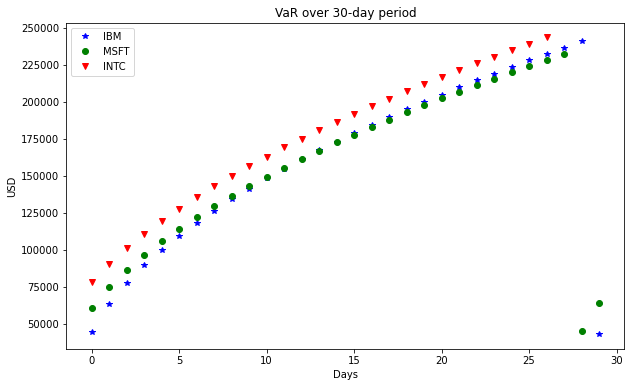

In [80]:
var_horizon = []
time_horizon = 30
for j in range(len(stocks_returns.columns)):
    for i in range(1, time_horizon):
        var_horizon.append(VaR_param[j] * np.sqrt(i))
plt.plot(var_horizon[:time_horizon], "o",
                  c='blue', marker='*', label='IBM')
plt.plot(var_horizon[time_horizon:time_horizon + 30], "o",
                  c='green', marker='o', label='MSFT')
plt.plot(var_horizon[time_horizon + 30:time_horizon + 60], "o",
                  c='red', marker='v', label='INTC')
plt.xlabel("Days")
plt.ylabel("USD")
plt.title("VaR over 30-day period")
    #plt.savefig('images/VaR_30_day.png')
plt.legend()
plt.show()
        